In [2]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import elicit as el

tfd = tfp.distributions

# Use a discrete likelihood
## Gradients for discrete RVs
### Challenge
+ ToDo (describe the problem of computing gradients for discrete RVs)
+ possible solution: softmax-gumble trick

### Possible work around: Softmax-Gumble Trick
+ Describe the softmax gumble trick

## Example: Binomial model

\begin{align*}
    \beta_0 &\sim \text{Normal}(\mu_0, \sigma_0) &\text{priors}\\
    \beta_1 &\sim \text{Normal}(\mu_1, \sigma_1) &\\
    \mu &= \text{sigmoid}(\beta_0 + \beta_1X) &\text{link+linear predictor} \\
    y_i &\sim \text{Binomial}(\mu, N) &\text{likelihood}
\end{align*}

+ using the `el.utils.softmax_gumble_trick()` function in the generative model

In [3]:
help(el.utils.softmax_gumbel_trick)

Help on function softmax_gumbel_trick in module elicit.utils:

softmax_gumbel_trick(epred: tensorflow.python.framework.tensor.Tensor, likelihood: <built-in function callable>, upper_thres: float, temp: float = 1.6, **kwargs)
    The softmax-gumbel trick computes a continuous approximation of ypred from
    a discrete likelihood and thus allows for the computation of gradients for
    discrete random variables.
    
    Currently this approach is only implemented for models without upper
    boundary (e.g., Poisson model).
    
    Corresponding literature:
    
    - Maddison, C. J., Mnih, A. & Teh, Y. W. The concrete distribution:
        A continuous relaxation of
      discrete random variables in International Conference on Learning
      Representations (2017). https://doi.org/10.48550/arXiv.1611.00712
    - Jang, E., Gu, S. & Poole, B. Categorical reparameterization with
    gumbel-softmax in International Conference on Learning Representations
    (2017). https://openreview.net/

### The generative model

In [3]:
class ToyModel:
    def __call__(self, prior_samples, design_matrix, total_count, temp,
                 **kwargs):
        B = prior_samples.shape[0]
        S = prior_samples.shape[1]

        # preprocess shape of design matrix
        X = tf.broadcast_to(design_matrix[None, None,:],
                           (B,S,len(design_matrix)))
        # linear predictor (= mu)
        epred = tf.add(prior_samples[:, :, 0][:,:,None],
                       tf.multiply(prior_samples[:, :, 1][:,:,None], X)
                       )
        # data-generating model
        likelihood = tfd.Binomial(
            total_count=total_count,
            probs=tf.math.sigmoid(tf.expand_dims(epred,-1)))

        # prior predictive distribution 
        ypred = el.utils.softmax_gumbel_trick(
            epred, likelihood, total_count, temp, **kwargs)
        
        # selected observations
        y_X0, y_X1, y_X2 = (ypred[:,:,0], ypred[:,:,1], ypred[:,:,2])

        return dict(y_X0=y_X0, y_X1=y_X1, y_X2=y_X2)

### Construct the predictor

In [4]:
# numeric, standardized predictor
def std_predictor(N, quantiles):
    X = tf.cast(np.arange(N), tf.float32)
    X_std = (X-tf.reduce_mean(X))/tf.math.reduce_std(X)
    X_sel = tfp.stats.percentile(X_std, [int(p*100) for p in quantiles])
    return X_sel

design_matrix = std_predictor(N=200, quantiles=[0.25, 0.50, 0.75])
design_matrix.numpy()

array([-0.85737586,  0.00866036,  0.85737586], dtype=float32)

### Oracle as expert

+ we simulate from a ground truth to obtain the expert data

\begin{align*}
    \beta_0 &\sim \text{Normal}(0.1, 0.4)\\
    \beta_1 &\sim \text{Normal}(0.2, 0.2)
\end{align*}

In [5]:
ground_truth = {
    "beta0": tfd.Normal(loc=0.1, scale=0.4),
    "beta1": tfd.Normal(loc=0.2, scale=0.2),
}

## Parametric approach
### Specify the ``eliobj``

In [7]:
eliobj = el.Elicit(
    model=el.model(
        obj=ToyModel,
        design_matrix=design_matrix,
        total_count = 30,
        temp = 1.6
        ),
    parameters=[
        el.parameter(
            name="beta0",
            family=tfd.Normal,
            hyperparams=dict(
                loc=el.hyper("mu0"),
                scale=el.hyper("sigma0", lower=0)
                )
        ),
        el.parameter(
            name="beta1",
            family=tfd.Normal,
            hyperparams=dict(
                loc=el.hyper("mu1"),
                scale=el.hyper("sigma1", lower=0)
                )
        )
    ],
    targets=[
        el.target(
            name=f"y_X{i}",
            query=el.queries.quantiles((.05, .25, .50, .75, .95)),
            loss=el.losses.MMD2(kernel="energy"),
            weight=1.0
        ) for i in range(3)
    ],
    expert=el.expert.simulator(
        ground_truth = ground_truth,
        num_samples = 10_000
    ),
    optimizer=el.optimizer(
        optimizer=tf.keras.optimizers.Adam,
        learning_rate=0.05,
        clipnorm=1.0
        ),
    trainer=el.trainer(
        method="parametric_prior",
        seed=0,
        epochs=300
    ),
    initializer=el.initializer(
        method="sobol",
        loss_quantile=0,
        iterations=32,
        distribution=el.initialization.uniform(
            radius=1.,
            mean=0.
            )
    )
)

### Train the ``eliobj``

In [8]:
eliobj.fit()

Initialization


100%|██████████| 32/32 [00:11<00:00,  2.69it/s]


 
Training


100%|██████████| 300/300 [02:56<00:00,  1.70it/s]


### Results
#### Convergence - Loss

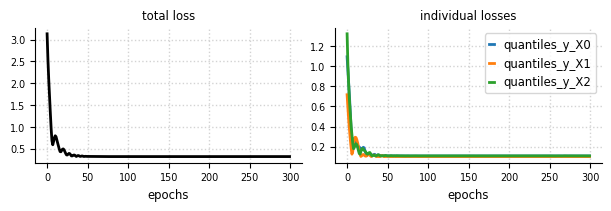

In [9]:
el.plots.loss(eliobj, figsize=(6,2))

#### Convergence - Hyperparameter

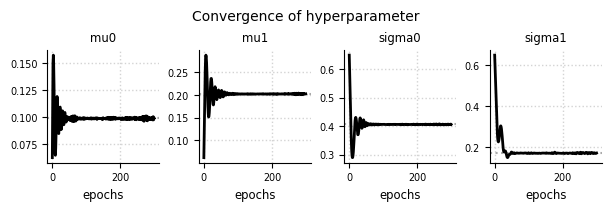

In [10]:
el.plots.hyperparameter(eliobj, figsize=(6,2))

#### Prior predictive distribution

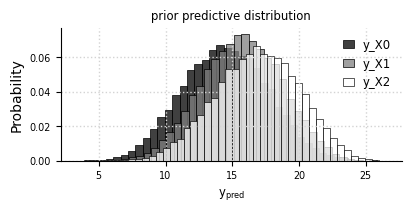

In [14]:
el.plots.priorpredictive(eliobj, figsize=(4,2))

#### Expert data (oracle) vs. simulated data

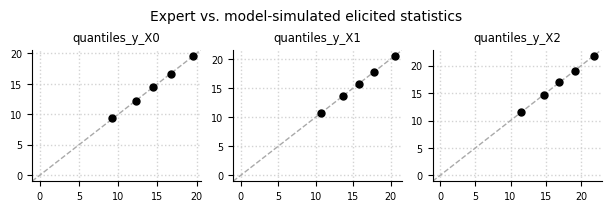

In [15]:
el.plots.elicits(eliobj, cols=3, figsize=(6,2))

#### Learned prior distributions

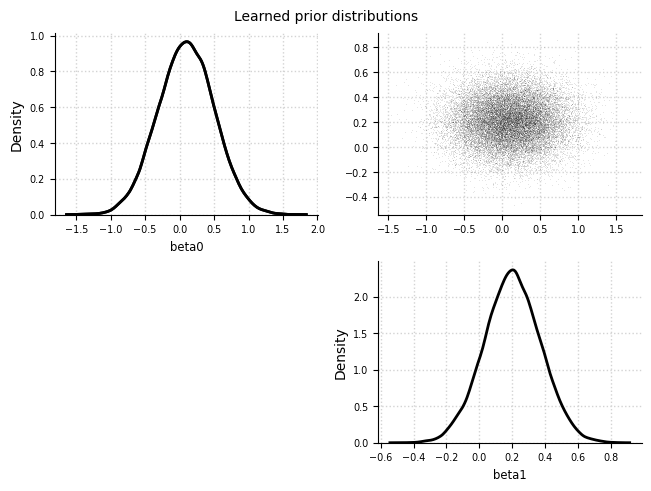

In [16]:
el.plots.priors(eliobj)

## Non-parametric approach
### Specify the ``eliobj``

In [6]:
from bayesflow.inference_networks import InvertibleNetwork

eliobj2 = el.Elicit(
    model=el.model(
        obj=ToyModel,
        design_matrix=design_matrix,
        total_count = 30,
        temp = 1.6
        ),
    parameters=[
        el.parameter(name="beta0"),
        el.parameter(name="beta1")
    ],
    targets=[
        el.target(
            name="y_X0",
            query=el.queries.quantiles((.05, .25, .50, .75, .95)),
            loss=el.losses.MMD2(kernel="energy"),
            weight=1.0
        ),
        el.target(
            name="y_X1",
            query=el.queries.quantiles((.05, .25, .50, .75, .95)),
            loss=el.losses.MMD2(kernel="energy"),
            weight=1.0
        ),
        el.target(
            name="y_X2",
            query=el.queries.quantiles((.05, .25, .50, .75, .95)),
            loss=el.losses.MMD2(kernel="energy"),
            weight=1.0
        )
    ],
    expert=el.expert.simulator(
        ground_truth = ground_truth,
        num_samples = 10_000
    ),
    optimizer=el.optimizer(
        optimizer=tf.keras.optimizers.Adam,
        learning_rate=0.001,
        clipnorm=1.0
        ),
    trainer=el.trainer(
        method="deep_prior",
        seed=0,
        epochs=200
    ),
    network=el.networks.NF(
        inference_network=InvertibleNetwork,
        network_specs=dict(
            num_params=2,
            num_coupling_layers=3,
            coupling_design="affine",
            coupling_settings={
                "dropout": False,
                "dense_args": {
                    "units": 128,
                    "activation": "relu",
                    "kernel_regularizer": None,
                },
                "num_dense": 2,
            },
            permutation="fixed"
        ),
        base_distribution=el.networks.base_normal
    )
)

### Train the ``eliobj``

In [7]:
eliobj2.fit()

Training


100%|██████████| 200/200 [05:31<00:00,  1.66s/it]


### Results
#### Convergence - Loss

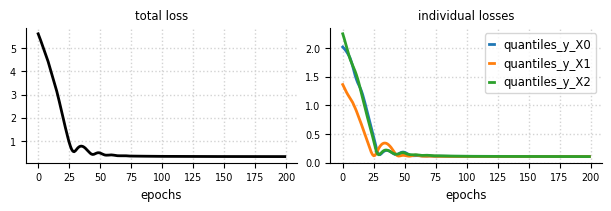

In [8]:
el.plots.loss(eliobj2, figsize=(6,2))

#### Convergence - Marginals

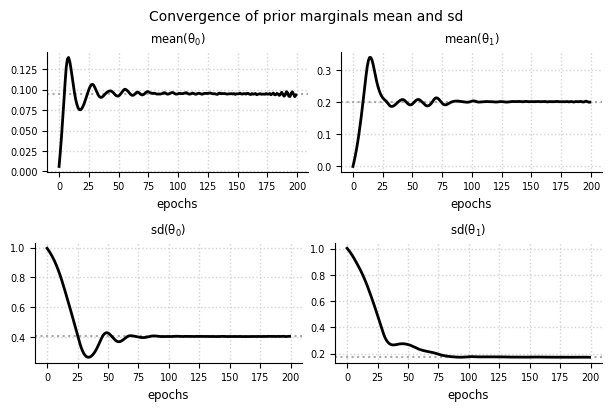

In [10]:
el.plots.marginals(eliobj2, cols=2, figsize=(6,4))

#### Prior predictive distribution

In [27]:
el.plots.priorpredictive(eliobj2, figsize=(4,2))

KeyError: 'ypred'

#### Expert data (oracle) vs. simulated data

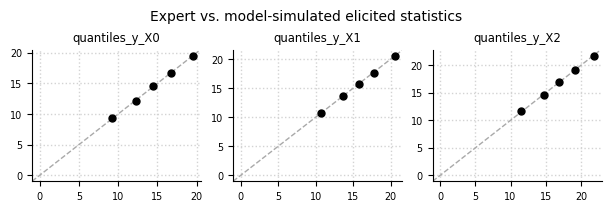

In [12]:
el.plots.elicits(eliobj2, cols=3, figsize=(6,2))

#### Learned prior distributions

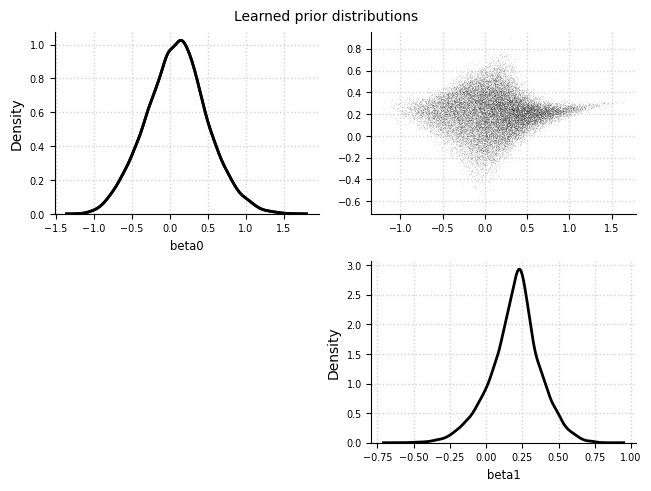

In [13]:
el.plots.priors(eliobj2)